# Summary

## Findings
* The gradient boosted model performed the best

## Actions
* Chose to move forward with the GB model and optimize

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Findings" data-toc-modified-id="Findings-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Findings</a></span></li><li><span><a href="#Actions" data-toc-modified-id="Actions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Actions</a></span></li></ul></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Evaluation</a></span></li><li><span><a href="#Model-Optimization" data-toc-modified-id="Model-Optimization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Optimization</a></span></li><li><span><a href="#Lightgbm" data-toc-modified-id="Lightgbm-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Lightgbm</a></span><ul class="toc-item"><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>XGBoost</a></span></li></ul></li></ul></div>

In [1]:
# Import needed libraries
import warnings
import seaborn as sns
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# ML Libraries
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve, cross_validate
from sklearn.metrics import (explained_variance_score, mean_absolute_error,,
                             mean_squared_error, mean_squared_log_error,
                             median_absolute_error, r2_score)

# Viz Libraries
from yellowbrick.model_selection import LearningCurve
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot

%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_pickle(
    'data/processed/listings_cleaned_processed_stepForward.pkl')

In [2]:
df.head()

,host_listings_count,accommodates,bathrooms,bedrooms,cleaning_fee,guests_included,extra_people,availability_30,review_scores_rating,median_home_value,population,distance_Downtown_LA,room_type_Private room,room_type_Shared room,clustered_location_1,price_log
0,1.0,2,1.0,1.0,0.0,1,0.0,29,93.0,278000,75774,30.827716,True,False,False,3.912023
1,2.0,2,1.5,1.0,10.0,1,5.0,1,92.0,278000,75774,36.517031,True,False,False,3.465736
2,2.0,2,1.0,1.0,0.0,1,8.0,20,95.0,278000,75774,36.228216,True,False,False,3.178054
3,1.0,4,2.0,2.0,0.0,1,0.0,19,96.0,278000,75774,36.253740,False,False,False,4.553877
4,1.0,2,1.5,1.0,0.0,1,15.0,0,97.0,278000,75774,37.519105,True,False,False,3.912023


In [3]:
X = df.drop(columns='price_log', axis=1)
y = df.price_log

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1234)

In [5]:
scaler = MinMaxScaler()
scaler.fit(X_train.iloc[:, :12])

scaled_X_train = scaler.transform(X_train.iloc[:, :12])
scaled_X_test = scaler.transform(X_test.iloc[:, :12])

X_train.iloc[:, :12] = scaled_X_train
X_test.iloc[:, :12] = scaled_X_test

C:\Users\peril\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\peril\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
classifiers = {
    'Gradient Boosting': GradientBoostingRegressor(random_state=123),
    'LGBM Regressor': LGBMRegressor(random_state=123, max_depth=3),
    'XGB': xgb.XGBRegressor(random_state=123, n_jobs=-1)
}

In [7]:
def model_viz(model, features):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

    try:
        feature_importance = pd.Series(model.feature_importances_, features)
    except:
        feature_importance = pd.Series(model.coef_, features)
    finally:
        top = feature_importance[list(
            feature_importance.abs().nlargest(20).index)].sort_values(
                ascending=True)
        top.plot(kind='barh', title='Feature Importance (Top 20)', ax=ax1)

    viz = LearningCurve(model, scoring='neg_mean_squared_error', cv=10, ax=ax2)
    viz.fit(X_train, y_train)
    viz.finalize()

    viz = ResidualsPlot(model, ax=ax3)
    viz.fit(X_train, y_train)
    viz.finalize()

    viz = PredictionError(model, ax=ax4)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()
    plt.tight_layout()
    plt.show()
    
def model_eval(name,clf):
    start = time.time()
    model = clf
    model.fit(X, y)
    predict = model.predict(X)
    features = [x for x in X.columns]  # List of features

    # Calculate Scores
    mse, rsquare, rmse, mae = mean_squared_error(y, predict), r2_score(
        y, predict), np.sqrt(mean_squared_error(
            np.exp(y), np.exp(predict))), median_absolute_error(
                np.exp(y), np.exp(predict))

    # Print the output reports
    display(Markdown(f'# Results For {name} Model'))
    display(
        Markdown(
            '### Mean Standard Error (MSE) :<span style="color:red"> %.3g</span>'
            % (mse)))
    print(
        "R Squared: %.3g | RMSE: %.3g | Median Absolute Error: %.3g"
        % (rsquare, rmse, mae))

    model_viz(model, features)

    end = time.time()
    runtime = (end - start)
    print('Elapsed Runtime: %.3g seconds' % (runtime))

    display(Markdown(f'***'))


results_overall = []


def overall_eval(results):
    display(Markdown('# Estimator Comparison'))
    columns = [
        'Estimator', 'Mean Standard Error', 'R-Squared', 'RMSE',
        'Median Absolute Error', 'Model Runtime'
    ]
    res = pd.DataFrame(results, columns=columns)
    col = [
        'Mean Standard Error', 'R-Squared', 'RMSE',
        'Median Absolute Error', 'Model Runtime'
    ]

    for c in col:
        f, axes = plt.subplots(figsize=(11, 5))
        sns.barplot(x=res[c], y=res['Estimator'],
                    palette='GnBu_d').set_title(c, fontsize=20)
        plt.show()


def RegressionPipeline(X, y):

    results = []

    for name, clf in classifiers.items():
        start = time.time()
        model = clf
        model.fit(X, y)
        predict = model.predict(X)
        features = [x for x in X.columns]  # List of features

        # Calculate Scores
        mse, rsquare, rmse, mae = mean_squared_error(y, predict), r2_score(
            y, predict), np.sqrt(mean_squared_error(
                np.exp(y), np.exp(predict))), median_absolute_error(
                    np.exp(y), np.exp(predict))

        # Print the output reports
        display(Markdown(f'# Results For {name} Model'))
        display(
            Markdown(
                '### Mean Standard Error (MSE) :<span style="color:red"> %.3g</span>'
                % (mse)))
        print(
            "R Squared: %.3g | RMSE: %.3g | Median Absolute Error: %.3g"
            % (rsquare, rmse, mae))

        model_viz(model, features)

        end = time.time()
        runtime = (end - start)
        print('Elapsed Runtime: %.3g seconds' % (runtime))

        display(Markdown(f'***'))

        results.append([name, mse, rsquare, rmse, mae, runtime])
        results_overall.append([name, mse, rsquare, rmse, mae, runtime])

    overall_eval(results)

# Model Evaluation

# Results For Gradient Boosting Model

### Mean Standard Error (MSE) :<span style="color:red"> 0.0807</span>

R Squared: 0.812 | RMSE: 42.9 | Median Absolute Error: 16.8


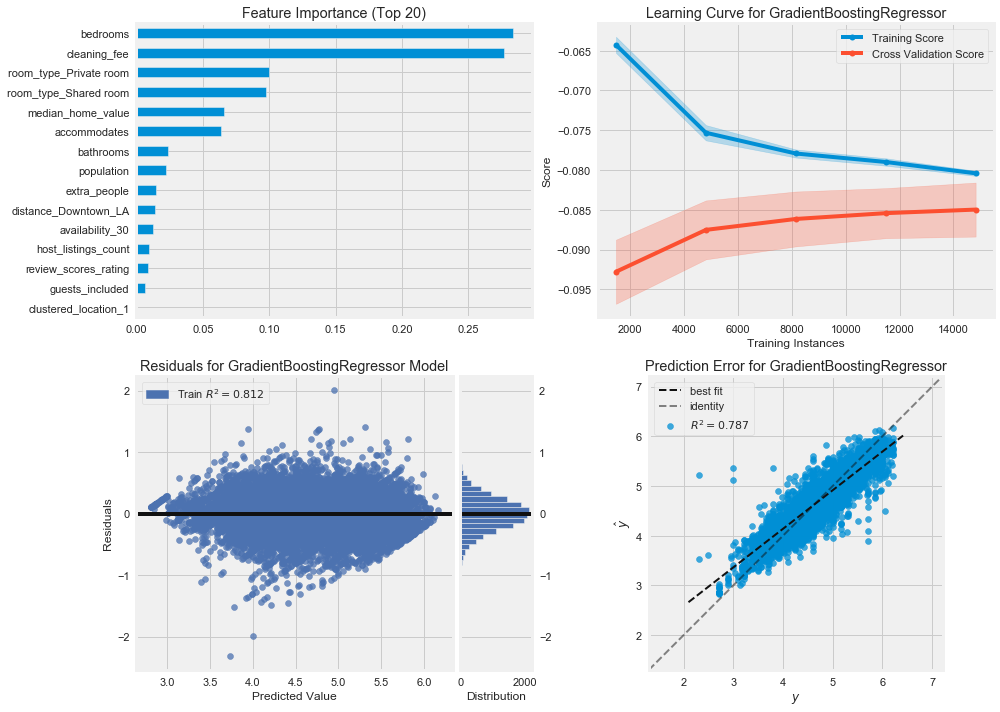

***

Elapsed Runtime: 23.9 seconds


# Results For LGBM Regressor Model

### Mean Standard Error (MSE) :<span style="color:red"> 0.081</span>

R Squared: 0.811 | RMSE: 42.9 | Median Absolute Error: 16.7


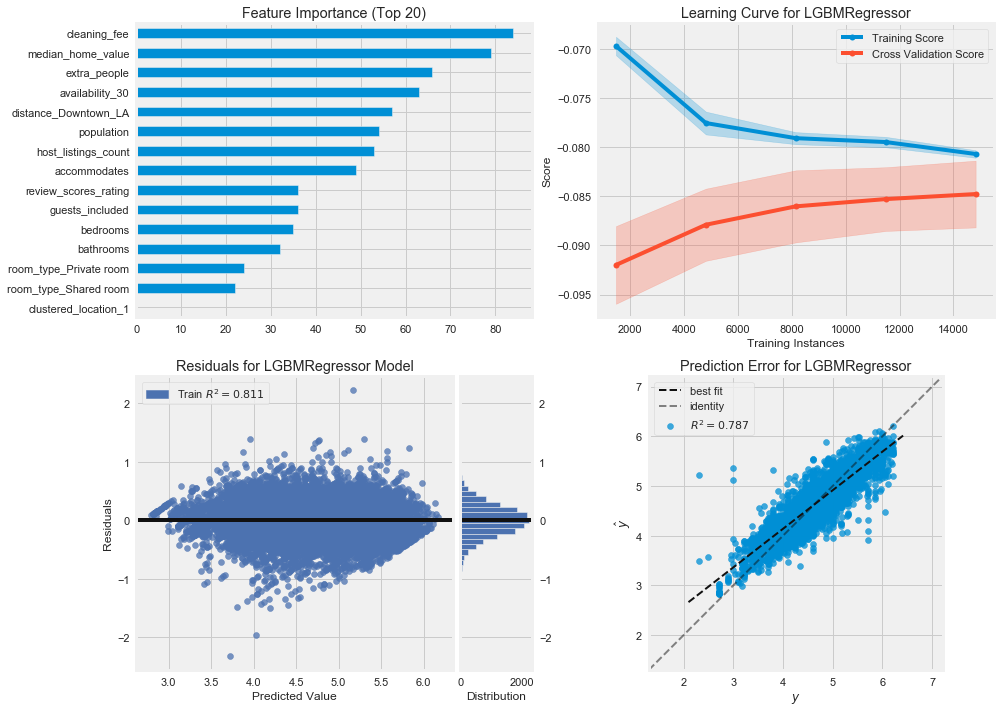

Elapsed Runtime: 6.42 seconds


***

# Results For XGB Model

### Mean Standard Error (MSE) :<span style="color:red"> 0.0808</span>

R Squared: 0.811 | RMSE: 42.9 | Median Absolute Error: 16.6


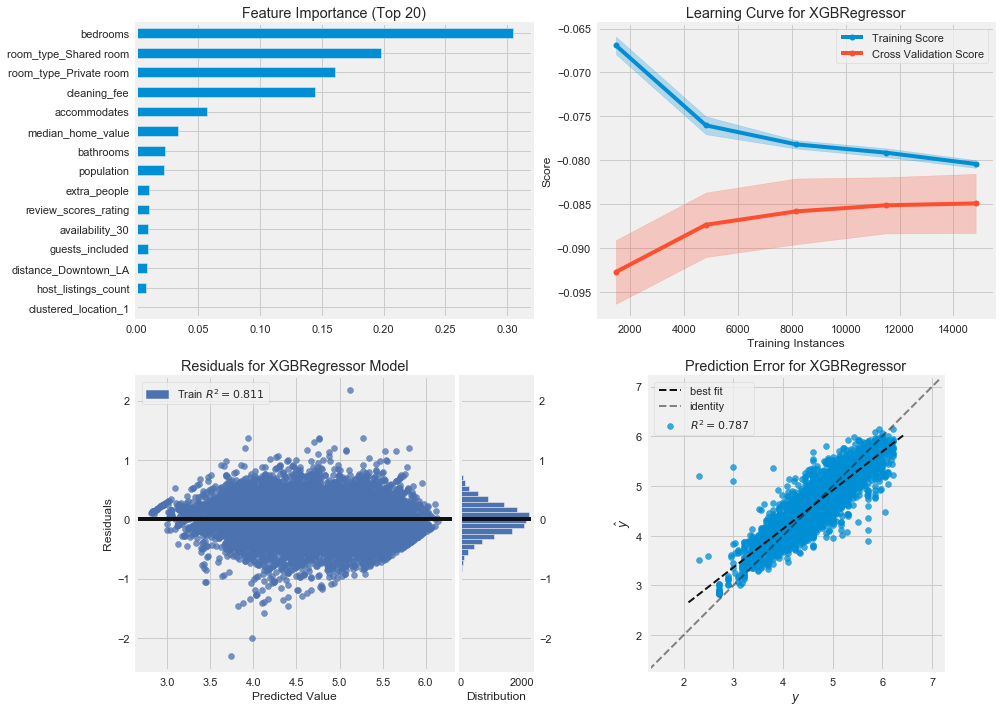

Elapsed Runtime: 17.6 seconds


***

# Estimator Comparison

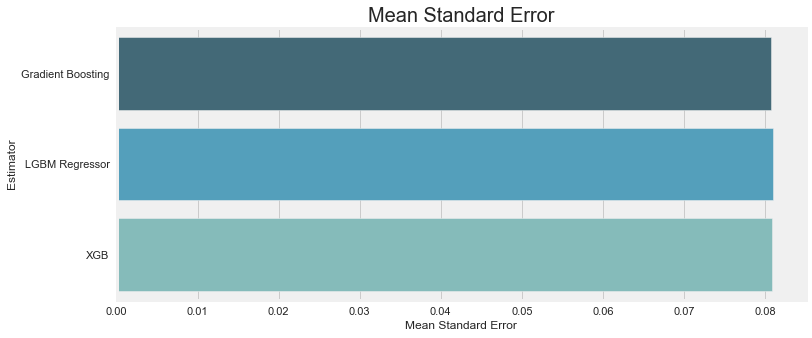

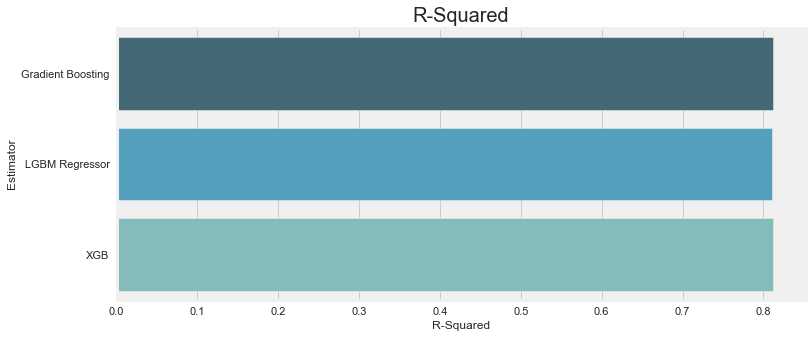

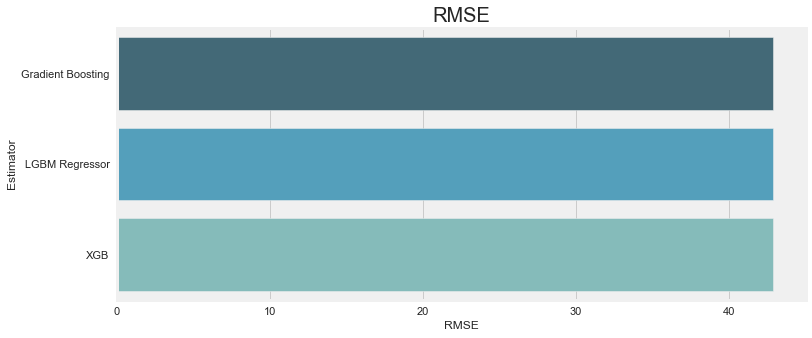

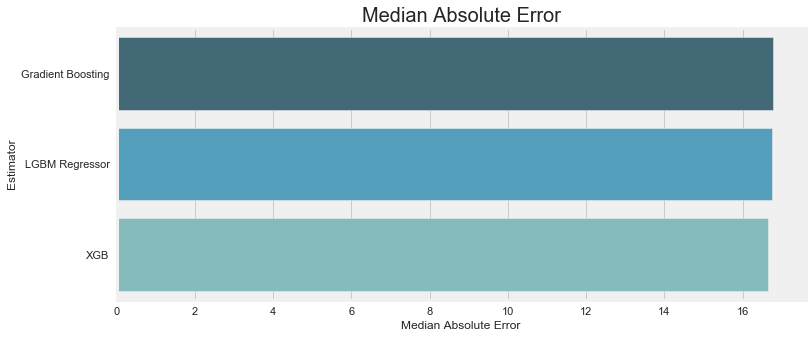

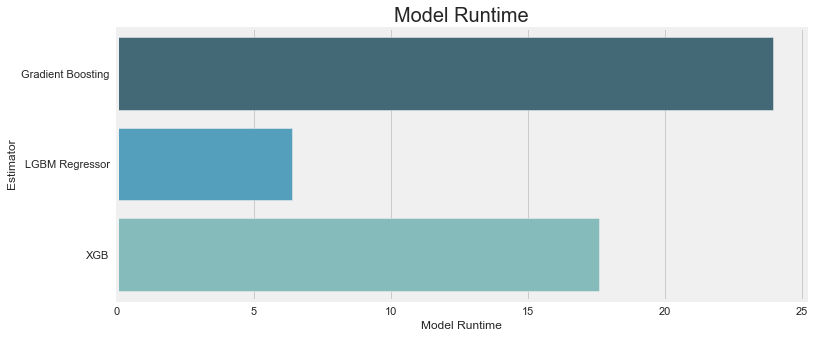

In [8]:
RegressionPipeline(X_train,y_train)

# Model Optimization

In [9]:
param_grid = {
    'loss': ['ls', 'lad', 'huber'],
    'learning_rate': np.arange(.1, .5, .05),
    'n_estimators': [100, 110, 120],
    'max_depth': [None, 5, 10]
}

# execute the grid search
model = GradientBoostingRegressor(random_state=123)
search = GridSearchCV(model,
                            param_grid,
                            cv=5,
                            verbose=2,
                            n_jobs=-1,
                            scoring='neg_mean_squared_error')
search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 49.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 69.0min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 73.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...e=123, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'loss': ['ls', 'lad', 'huber'], 'learning_rate': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]), 'n_estimators': [100, 110, 120], 'max_depth': [None, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [10]:
search.best_params_ 

{'learning_rate': 0.20000000000000004,
 'loss': 'huber',
 'max_depth': 5,
 'n_estimators': 120}

# Results For Gradient Boosting Model

### Mean Standard Error (MSE) :<span style="color:red"> 0.0601</span>

R Squared: 0.86 | RMSE: 36.3 | Median Absolute Error: 13.9


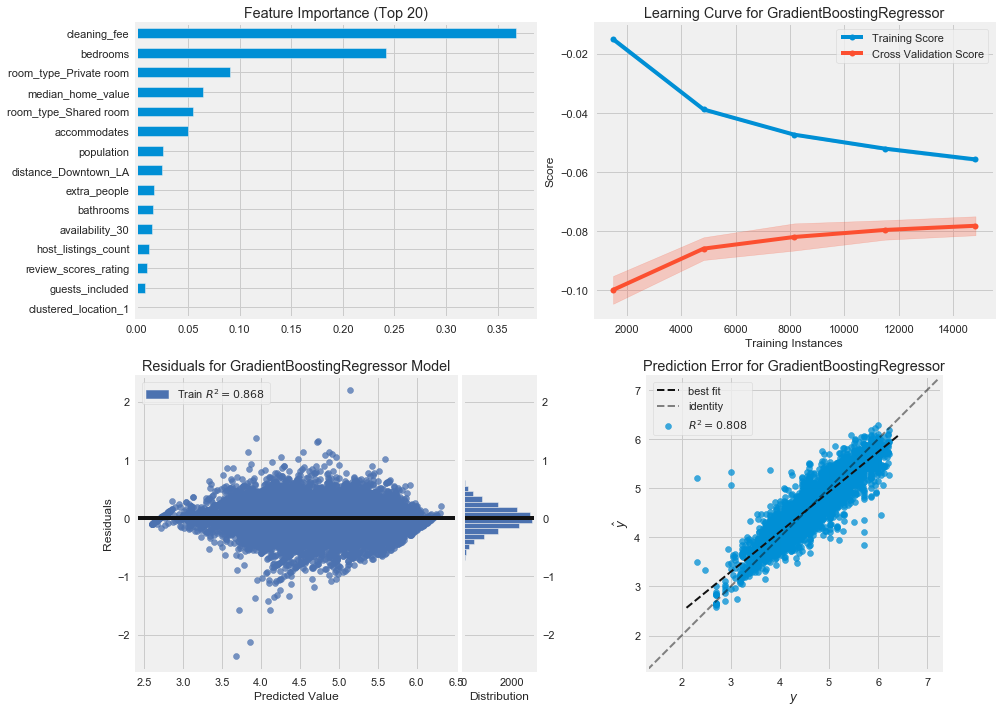

Elapsed Runtime: 71.6 seconds


***

In [11]:
features = [x for x in X.columns]
model_eval('Gradient Boosting',search.best_estimator_)

In [12]:
model = search.best_estimator_
predict = model.predict(X_test)
print(f'R2 = {model.score(X_test, y_test)}')
print(f'RMSE = {np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predict)))}')
print(f'Median Absolute Error = {median_absolute_error(np.exp(y_test), np.exp(predict))}')

R2 = 0.8075802437793964
RMSE = 44.31222765112785
Median Absolute Error = 15.689353932858868


In [13]:
# # save the model
# import pickle
# pickle.dump(model, open('models\los_angeles_2020.sav', 'wb'))

# Lightgbm

In [14]:
param_grid = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'learning_rate': np.arange(.1, .5, .05),
    'n_estimators': [100, 110, 120, 130, 140, 200],
    'max_depth': [None, 5, 10]
}

# execute the grid search
model = LGBMRegressor(random_state=123)
search = GridSearchCV(model,
                            param_grid,
                            cv=5,
                            verbose=2,
                            n_jobs=-1,
                            scoring='neg_mean_squared_error')
search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  4.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'boosting_type': ['gbdt', 'dart', 'goss'], 'learning_rate': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]), 'n_estimators': [100, 110, 120, 130, 140, 200], 'max_depth': [None, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [15]:
search.best_params_ 

{'boosting_type': 'gbdt',
 'learning_rate': 0.15000000000000002,
 'max_depth': 5,
 'n_estimators': 200}

# Results For LightGBM Model

### Mean Standard Error (MSE) :<span style="color:red"> 0.0598</span>

R Squared: 0.861 | RMSE: 36.5 | Median Absolute Error: 14.4


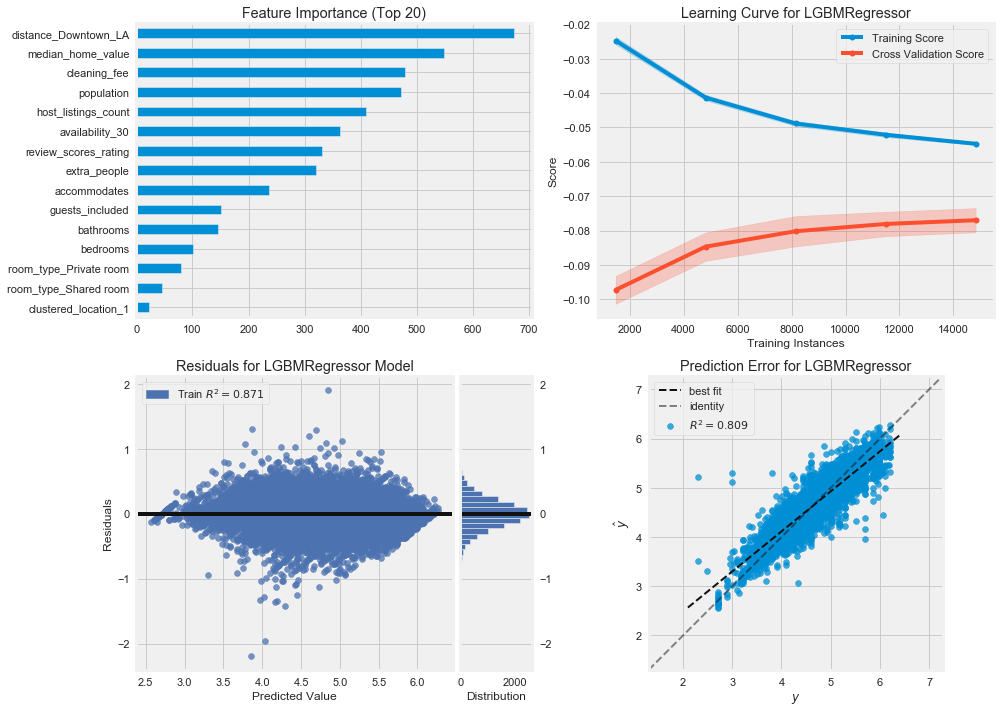

Elapsed Runtime: 9.57 seconds


***

In [16]:
features = [x for x in X.columns]
model_eval('LightGBM',search.best_estimator_)

In [17]:
model = search.best_estimator_
predict = model.predict(X_test)
print(f'R2 = {model.score(X_test, y_test)}')
print(f'RMSE = {np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predict)))}')
print(f'Median Absolute Error = {median_absolute_error(np.exp(y_test), np.exp(predict))}')

R2 = 0.8092515093320514
RMSE = 44.03816807059961
Median Absolute Error = 15.891676435381491


## XGBoost

In [22]:
param_grid = {
    'booster': ['gbtree', 'gblinear'],
    'learning_rate': np.arange(.1, .3, .05),
    'n_estimators': [100, 125, 150, 175, 200],
    'max_depth': [3, 5, 10]
}

# execute the grid search
model = xgb.XGBRegressor(random_state=123, n_jobs=-1)
search = GridSearchCV(model,
                            param_grid,
                            cv=5,
                            verbose=2,
                            n_jobs=-1,
                            scoring='neg_mean_squared_error')
search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.9min
C:\Users\peril\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  3.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=123, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'booster': ['gbtree', 'gblinear'], 'learning_rate': array([0.1 , 0.15, 0.2 , 0.25]), 'n_estimators': [100, 125, 150, 175, 200], 'max_depth': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [23]:
search.best_params_ 

{'booster': 'gbtree',
 'learning_rate': 0.15000000000000002,
 'max_depth': 5,
 'n_estimators': 200}

# Results For XGBoost Model

### Mean Standard Error (MSE) :<span style="color:red"> 0.057</span>

R Squared: 0.867 | RMSE: 35.5 | Median Absolute Error: 13.9


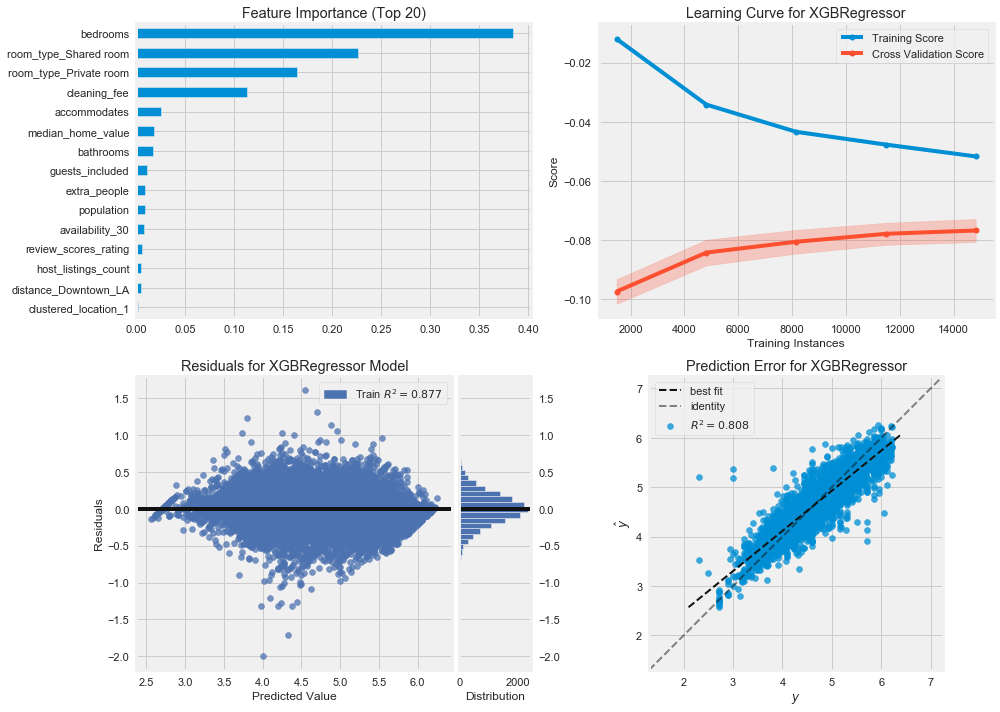

Elapsed Runtime: 39.1 seconds


***

In [24]:
features = [x for x in X.columns]
model_eval('XGBoost',search.best_estimator_)

In [25]:
model = search.best_estimator_
predict = model.predict(X_test)
print(f'R2 = {model.score(X_test, y_test)}')
print(f'RMSE = {np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predict)))}')
print(f'Median Absolute Error = {median_absolute_error(np.exp(y_test), np.exp(predict))}')

R2 = 0.807795916926443
RMSE = 44.28862770608317
Median Absolute Error = 15.8516426086426
